In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

读取照片

In [2]:
# 定义参数
# input_size = 28 # 输入图像大小
# num_classes = 2 # 标签的种类数
# num_epochs = 3 # 训练的循环周期
# batch_size = 7 # 一批次处理7张图片
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 数据增强
data_transforms = {
    'Train': transforms.Compose([
        transforms.CenterCrop(224), # 随机裁剪为224*224, resnet要求
        transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转，概率为0.5
        transforms.RandomRotation(45), # 随机旋转-45°到45°
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # 亮度，对比度，饱和度，色相
        transforms.RandomGrayscale(p=0.025), # 0.025概率随机变为灰度率
        transforms.ToTensor(), # 变为张量
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 均值 标准差
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转，概率为0.5
        transforms.RandomRotation(45), # 随机旋转-45°到45°
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # 亮度，对比度，饱和度，色相
        transforms.RandomGrayscale(p=0.025), # 0.025概率随机变为灰度率
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
}
# 训练集
data_dir = "New Masks Dataset"
img_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=256,
                                              shuffle=True, num_workers=4)
               for x in ['Train', 'Test']}
class_names = img_datasets['Train'].classes

In [3]:
dataloaders

{'Train': <torch.utils.data.dataloader.DataLoader at 0x2424cd80be0>,
 'Test': <torch.utils.data.dataloader.DataLoader at 0x2424cd806d0>}

In [4]:
img_datasets["Train"]

Dataset ImageFolder
    Number of datapoints: 8000
    Root location: New Masks Dataset\Train
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomGrayscale(p=0.025)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
class_names

['with_mask', 'without_mask']

In [6]:
# datasets数据展示， 对数据加强中的数据进行逆操作
def img_show(tensor, title=None):
    image = tensor.numpy().transpose((1, 2, 0))

    image = image * np.array((0.229, 0.224, 0.225) + np.array((0.485, 0.456, 0.406)))
    image = image.clip(0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

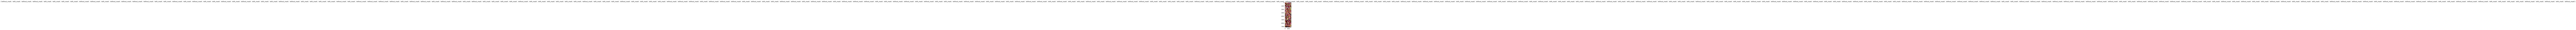

In [7]:
inputs, classes = next(iter(dataloaders["Train"]))
out = torchvision.utils.make_grid(inputs)
img_show(out, title=[class_names[x] for x in classes])

In [8]:
torchvision.models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

试一下resnet18

In [9]:
model_fit_ = torchvision.models.resnet18()
model_fit_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# 使用out layer以前训练好的层
feature_extract = True

In [11]:
def set_parameter_requires_grad(input_model, feature_extracting):
    if feature_extracting:
        for param in input_model.parameters():
            param.requires_grad = False

In [12]:
def initialize_resnet18(extract_feature, num_out):
    model_ft = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    set_parameter_requires_grad(model_ft, extract_feature)
    num_features = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_features, num_out)
    return model_ft

In [13]:
model_ft = initialize_resnet18(True,2)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:

print("需要学习调整的参数:")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)

else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            print("\t", name)


需要学习调整的参数:
	 fc.weight
	 fc.bias


优化器

In [15]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.1)
criterion = nn.NLLLoss()

训练

In [16]:
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()

In [17]:
print(dataloaders["Train"])

In [18]:
for inputs, classes in dataloaders["Train"]:
    print(inputs)
    print("classes", classes)


'for inputs, classes in dataloaders["Train"]:\n    print(inputs)\n    print("classes", classes)'

In [19]:
for batch, sets in enumerate(dataloaders):
    for i, (inputs, classes) in enumerate(dataloaders["Train"]):
        print("--------",i)
        print(inputs)
        print(classes)

'for batch, sets in enumerate(dataloaders):\n    for i, (inputs, classes) in enumerate(dataloaders["Train"]):\n        print("--------",i)\n        print(inputs)\n        print(classes)'

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        _, out_pred = torch.max(model(X), 1)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 8 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, acc_list, loss_list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    acc_list.append(correct*100)
    loss_list.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
acc_list = []
loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloaders["Train"], model_ft, loss_fn, optimizer_ft)
    test_loop(dataloaders["Test"], model_ft, loss_fn, acc_list, loss_list)
print("Done!")

Epoch 1
-------------------------------
loss: 0.819911  [    0/ 8000]
loss: 0.698577  [ 2048/ 8000]
loss: 0.706900  [ 4096/ 8000]
loss: 0.679429  [ 6144/ 8000]
Test Error: 
 Accuracy: 35.8%, Avg loss: 0.845405 

Epoch 2
-------------------------------
loss: 0.653790  [    0/ 8000]
loss: 0.634869  [ 2048/ 8000]
loss: 0.632053  [ 4096/ 8000]
loss: 0.614741  [ 6144/ 8000]
Test Error: 
 Accuracy: 42.6%, Avg loss: 0.787733 

Epoch 3
-------------------------------
loss: 0.621519  [    0/ 8000]
loss: 0.576376  [ 2048/ 8000]
loss: 0.553161  [ 4096/ 8000]
loss: 0.546149  [ 6144/ 8000]
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.759304 

Epoch 4
-------------------------------
loss: 0.546346  [    0/ 8000]
loss: 0.519811  [ 2048/ 8000]
loss: 0.513052  [ 4096/ 8000]
loss: 0.535245  [ 6144/ 8000]
Test Error: 
 Accuracy: 52.4%, Avg loss: 0.728026 

Epoch 5
-------------------------------
loss: 0.495064  [    0/ 8000]
loss: 0.497735  [ 2048/ 8000]


图展示结果

In [ ]:
acc_ = [68.0, 76.0, 81.0, 86.0, 79.0, 81.0, 84.0, 79.0, 85.0, 78.0, 82.0, 81.0, 87.0, 78.0, 82.0, 88.0, 86.0, 84.0, 86.0, 89.0, 91.0, 86.0, 83.0, 85.0, 81.0, 87.0, 87.0, 82.0, 88.0, 84.0, 85.0, 87.0, 87.0, 87.0, 87.0, 87.0, 92.0, 84.0, 90.0, 90.0, 88.0, 83.0, 86.0, 83.0, 84.0, 82.0, 89.0, 81.0, 92.0, 91.0]
epoch_ = [i for i in range(1, 11)]
loss_ = [0.614288, 0.557294, 0.487522, 0.457194, 0.488358, 0.435121, 0.383316, 0.467714, 0.406804, 0.456730, 0.426332, 0.433169, 0.369941, 0.486823, 0.397050, 0.340567, 0.354762, 0.371264, 0.376313, 0.313482, 0.323789, 0.341476, 0.321718, 0.380739, 0.398366, 0.373900, 0.312948, 0.385505, 0.318215, 0.344609, 0.361870, 0.359009, 0.351973, 0.338048, 0.316605, 0.327947, 0.265936, 0.327100, 0.270373, 0.284021, 0.303596, 0.365134, 0.355562, 0.389704, 0.334369, 0.415306, 0.312101, 0.382107, 0.291153, 0.263090]

In [ ]:
def draw_acc_result(acc, epoch_time):
    y = np.array(acc)
    x = np.array(epoch_time)
    plt.plot(x, y)

    plt.title('Accuracy Epoch Line Chart')
    plt.ylabel('y-accuracy')
    plt.xlabel('x-epoch')
    plt.show()

In [ ]:
draw_acc_result(acc_list, epoch_)

In [ ]:
def draw_loss_result(loss, epoch_time):
    y = np.array(loss)
    x = np.array(epoch_time)
    plt.plot(x, y)

    plt.title('Loss Epoch Line Chart')
    plt.ylabel('y-loss')
    plt.xlabel('x-epoch')
    plt.show()

In [ ]:
draw_loss_result(loss_list, epoch_)